In [2]:
# Install required libraries
#!pip install pytorch-metric-learning
#!pip install torchvision

# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
from pytorch_metric_learning import losses, miners, samplers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import os
import zipfile
import random
import numpy as np
from sklearn.manifold import TSNE

# Set up data paths
data_path = "/content/sample_data/Stanford_Online_Products"
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Download and extract Stanford Online Products dataset
#!wget http://ftp.cs.stanford.edu/cs/cvgl/Stanford_Online_Products.zip -P /content/sample_data
#!unzip /content/sample_data/Stanford_Online_Products.zip -d /content/sample_data



In [18]:
#!pip install faiss-gpu
#import faiss

In [4]:
# Set up data paths
data_path = "/content/sample_data/Stanford_Online_Products"
train_path = "/content/sample_data/train"
test_path = "/content/sample_data/test"

# Extract Stanford Online Products dataset
with zipfile.ZipFile("/content/sample_data/Stanford_Online_Products.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/sample_data/")



In [5]:
# Create train and test directories
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

# Split data into train and test
all_classes = os.listdir(data_path)
for cls in all_classes:
    class_path = os.path.join(data_path, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images = images[:split_idx]
        test_images = images[split_idx:]
        train_class_path = os.path.join(train_path, cls)
        test_class_path = os.path.join(test_path, cls)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        for img in train_images:
            os.rename(os.path.join(class_path, img), os.path.join(train_class_path, img))
        for img in test_images:
            os.rename(os.path.join(class_path, img), os.path.join(test_class_path, img))

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Sample a subset of the training dataset for faster training
subset_indices = random.sample(range(len(train_dataset)), 500)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

# Sampler for metric learning
subset_labels = [train_dataset.targets[i] for i in subset_indices]
sampler = samplers.MPerClassSampler(
    labels=subset_labels,
    m=4,
    length_before_new_iter=len(subset_indices)
)

# Data loaders (only needed for the test set)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 128)  # Modify the final layer for embeddings
model = model.to(device)

# Define loss and miner
loss_fn = losses.TripletMarginLoss(margin=0.2)
miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="hard")

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set up the trainer with the required arguments
trainer = trainers.MetricLossOnly(
    models={'trunk': model},
    optimizers={'trunk_optimizer': optimizer},
    batch_size=32,
    loss_funcs={'metric_loss': loss_fn},
    mining_funcs={'tuple_miner': miner},
    dataset=train_subset,
    sampler=sampler,
    dataloader_num_workers=2,
    data_device=device
)

# Train the model
num_epochs = 5
trainer.train(num_epochs=num_epochs)

# Note: Recording the loss may require a custom hook or additional code.

# After training, proceed with evaluation and visualization as before.

# Set the model to evaluation mode
model.eval()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
total_loss=0.21546: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def get_embeddings_labels(model, dataloader, device):
    model.eval()
    embeddings_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model(images)
            embeddings_list.append(embeddings.cpu())
            labels_list.append(labels)
    embeddings = torch.cat(embeddings_list)
    labels = torch.cat(labels_list)
    return embeddings, labels

# Use the custom function
embeddings, labels = get_embeddings_labels(model, test_loader, device)

In [11]:
# Get embeddings and labels from the test set
embeddings, labels = get_embeddings_labels(model, test_loader, device)



In [14]:
# Evaluate the model using AccuracyCalculator
accuracy_calculator = AccuracyCalculator(k=5)
trunk_output = []
labels_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        embeddings = model(images)
        trunk_output.append(embeddings.cpu())
        labels_list.append(labels)
embeddings = torch.cat(trunk_output)
labels = torch.cat(labels_list)
accuracy = accuracy_calculator.get_accuracy(embeddings, labels, embeddings, labels)
print("Test set accuracy:", accuracy)

If you're looking for MAP@5 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Test set accuracy: {'AMI': 0.09466704727683177, 'NMI': 0.09519605683071418, 'mean_average_precision': 0.0006264100760039675, 'mean_average_precision_at_r': 0.0006264100760039675, 'mean_reciprocal_rank': 0.9998804330825806, 'precision_at_1': 0.9997683898462109, 'r_precision': 0.4860339077265147}


"You are computing {'mean_average_precision_at_r', 'r_precision'}, but the value for k (5) is less than the max bin count (4932) so the values for these metrics will be incorrect. To fix this, set k='max_bin_count'."

The message means that the value of k we've set (which is 5) in the AccuracyCalculator is smaller than the maximum number of relevant items (4932) in your dataset. Metrics like Recall@k and MAP@k depend on k being at least as large as the maximum number of relevant items per query to be accurate. When k is less than this maximum, these metrics can't be computed correctly because they won't consider all possible relevant items. To fix this, we should set k='max_bin_count', which automatically adjusts k to match the maximum possible value, ensuring accurate computation of these evaluation metrics. **bold text**

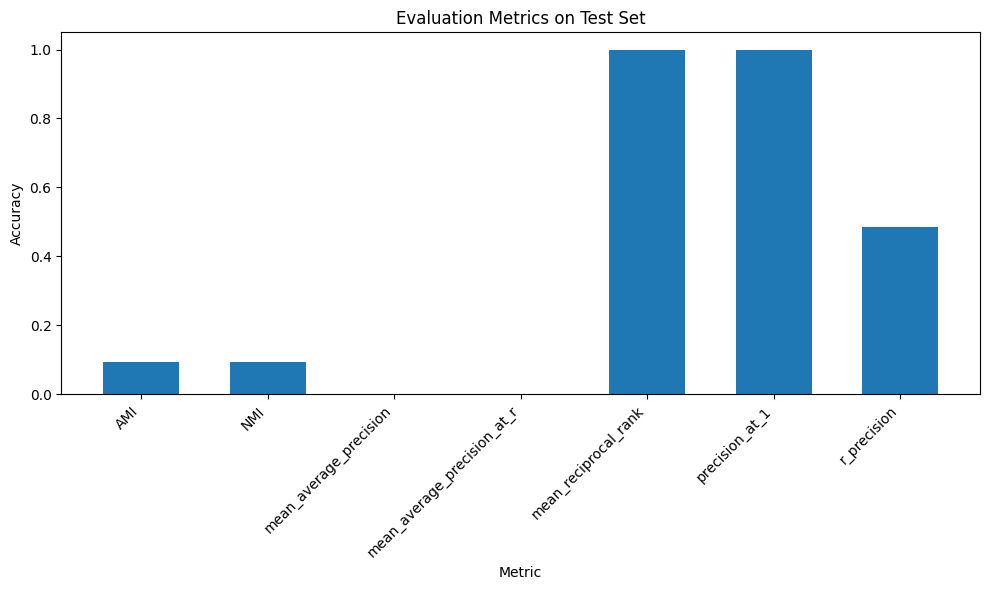

In [16]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracy)), list(accuracy.values()), tick_label=list(accuracy.keys()), width=0.6)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metric')
plt.ylabel('Accuracy')
plt.title('Evaluation Metrics on Test Set')
plt.tight_layout()
plt.show()

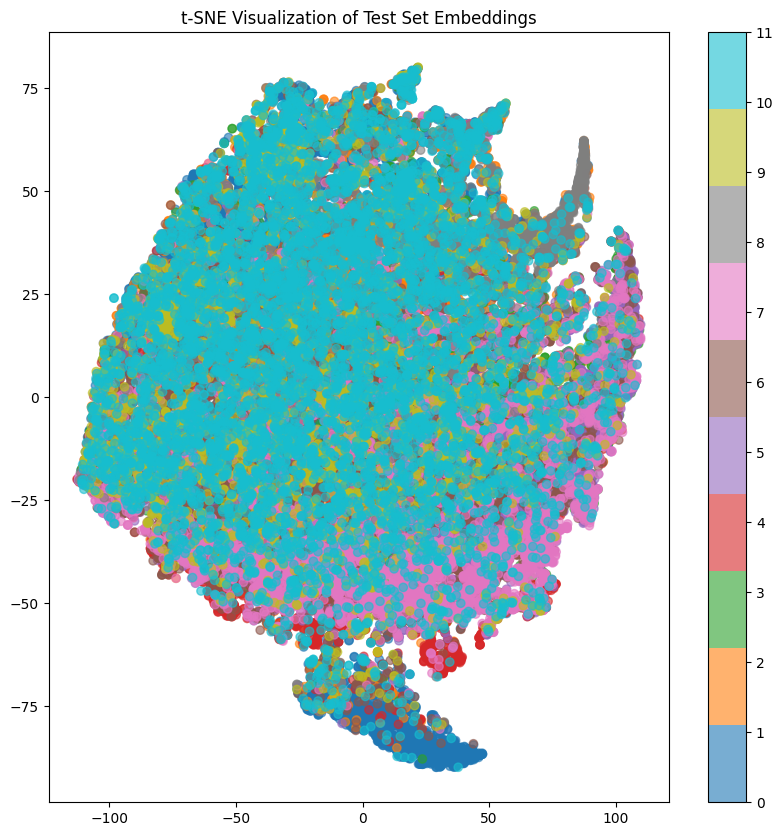

In [17]:
# Visualize the embedding space using t-SNE
embeddings_np = embeddings.numpy()
labels_np = labels.numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(len(set(labels_np))))
plt.title('t-SNE Visualization of Test Set Embeddings')
plt.show()

In [ ]:
# Inference pipeline
def inference(model, data_loader, device):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings)

# Running inference on test set
test_embeddings = inference(model, test_loader, device)
print("Inference completed. Number of test embeddings:", test_embeddings.shape[0])

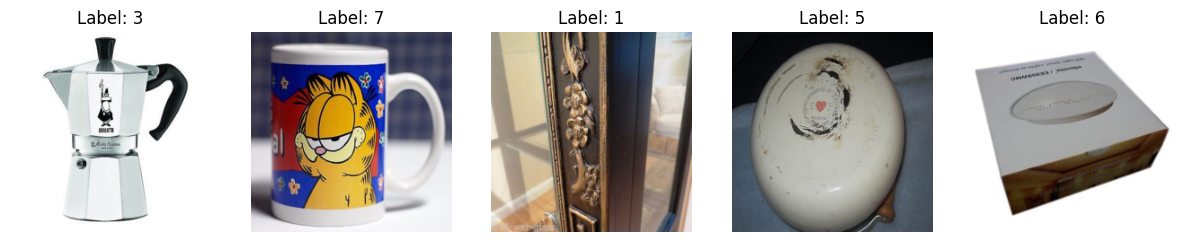

In [19]:
# Visualize few samples from the dataset
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = torch.clamp(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Visualize training samples
visualize_samples(train_dataset)


KeyboardInterrupt: 

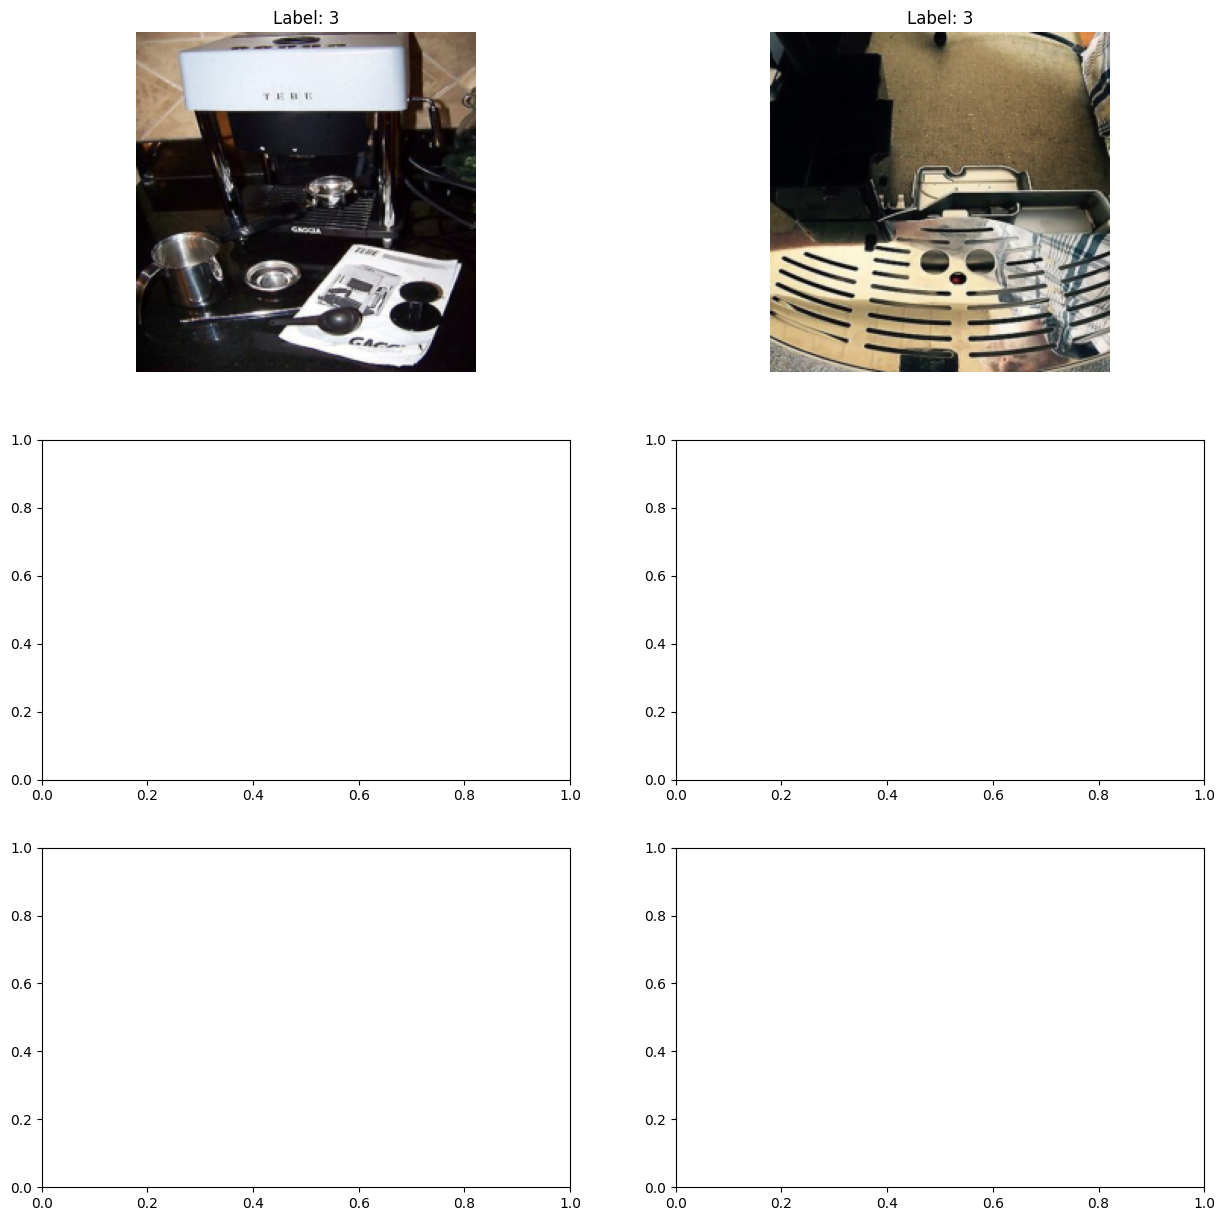

In [21]:
# Visualize similar samples with specified labels
def visualize_similar_samples(dataset, labels, num_samples_per_label=5):
    fig, axes = plt.subplots(len(labels), num_samples_per_label, figsize=(15, 5 * len(labels)))
    for i, label in enumerate(labels):
        label_indices = [idx for idx, (_, lbl) in enumerate(dataset) if lbl == label]
        selected_indices = random.sample(label_indices, min(num_samples_per_label, len(label_indices)))
        for j, idx in enumerate(selected_indices):
            image, lbl = dataset[idx]
            image = image.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
            image = torch.clamp(image, 0, 1)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"Label: {lbl}")
            axes[i, j].axis('off')
    plt.show()

# Visualize 5 similar images for labels 3, 1, and 4
visualize_similar_samples(train_dataset, labels=[3, 1, 4], num_samples_per_label=2)